# CAB420, Practical 6 - Question 2
Linear Discriminant Analysis is designed to find a re-projection of the data such that it maximises the distance between the classes, while ensuring that samples of the same class are tightly grouped. As such, it has been widely applied to biometrics. One such method is FisherFaces, which applies PCA and then LDA to help group faces of the same subject. In brief, FisherFaces operates as follows:
* Construct an image matrix, where each row is a vectorised version of an image (i.e. as was done for EigenFaces)
* Project this matrix into an N-C space (N is the number of samples or dimensions, which ever is smaller; C is the number of unique classes) using PCA.
* Apply LDA to the subspace that results from the PCA transform, i.e.:
 * Compute the between class scatter matrix in the projected space;
 * Compute the within class scatter matrix in the projected space;
 * Compute the eigenvalues and eigenvectors of the ratio of the scatter matrices.
* Learn a classifier (i.e. k-nearest neighbours) in the final LDA space.

New samples can now be mapped to the FisherFace space by applying the PDA projection followed by the LDA projection. Using this classifier:
* Compare the performance of the two methods using the test set of the YaleB dataset.
* Compare the performance of the two methods using the two additional datasets: Yale_32x32.mat and ORL_32x32.mat. You should not re-train the PCA or LDA subspace using this data.
* Compare the performance of EigenFaces as the number of retained PCA components changes, to FisherFaces when equivalent changes are made to the number of retained components in the LDA space (note, do not reduce the number of components in the initial PCA projection for FisherFaces).

More information on FisherFaces can be found in the original paper, or online in posts such as this one: https://www.bytefish.de/blog/fisherfaces/.

### Relevant Examples

The LDA example, ``CAB420_Dimension_Reduction_Example_4_Linear_Discriminant_Analysis_II_Action_Time.ipynb`` and the eigenfaces example, ``CAB420_Dimension_Reduction_Example_5_Eigenfaces.ipynb`` are the most relevant here.

### Suggested Packages

It's sklearn again in this one.

In [1]:
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

### Part 1: Preliminaries
Load data, compute PCA space, etc. This is identical to Q1.

In [21]:
yale_b = scipy.io.loadmat('YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

rng = numpy.random.default_rng(seed = 42)

train_set_index = numpy.where(gnd < 30)[0]
train_fea = fea[train_set_index, :]
train_gnd = gnd[train_set_index, :]
train_gnd = numpy.reshape(train_gnd, -1)

test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_set_index, 0)
test_gnd = numpy.delete(test_gnd, train_set_index, 0)

probe_frames = numpy.array(()).astype('int')
for i in numpy.unique(test_gnd):    
    indexes = numpy.where(test_gnd == i)[0]
    count = len(indexes);
    f = rng.choice(indexes, 16, replace=False)
    probe_frames = numpy.append(probe_frames, f)

gallery_fea = test_fea
gallery_gnd = test_gnd
gallery_fea = numpy.delete(gallery_fea, probe_frames, 0)
gallery_gnd = numpy.delete(gallery_gnd, probe_frames, 0)
probe_fea = test_fea[probe_frames, :]
probe_gnd = test_gnd[probe_frames, :]
gallery_gnd = numpy.reshape(gallery_gnd, -1)
probe_gnd = numpy.reshape(probe_gnd, -1)

print(train_fea.shape)
print(train_gnd.shape)
print(gallery_fea.shape)
print(gallery_gnd.shape)
print(probe_fea.shape)
print(probe_gnd.shape)

(1838, 1024)
(1838,)
(432, 1024)
(432,)
(144, 1024)
(144,)


In [22]:
pca = decomposition.PCA()
pca.fit(train_fea)

transformed = pca.transform(gallery_fea)
transformed_test = pca.transform(probe_fea)

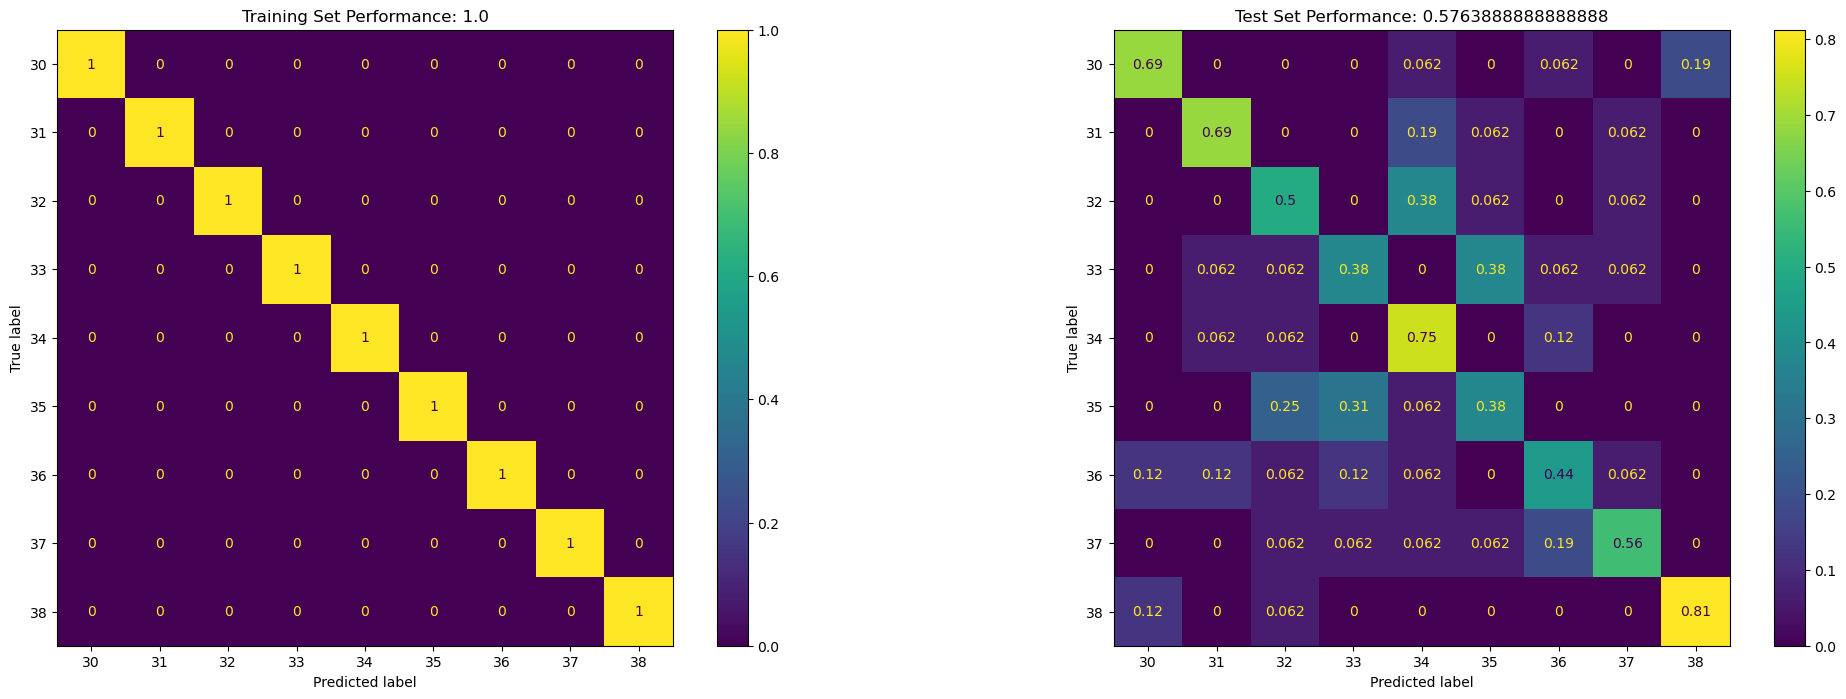

In [24]:
cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]

transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));    
    
cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_95.fit(transformed_train_95, gallery_gnd)
eval_model(cknn_95, transformed_train_95, gallery_gnd, transformed_test_95, probe_gnd)    

### Part 2: LDA

Here you need to apply LDA to the data after transforming using PCA.

#### Transform data using PCA ready for LDA

In [29]:
dims_to_keep = train_fea.shape[1] - len(numpy.unique(train_gnd))

transformed_train = pca.transform(train_fea)
transformed_gallery = pca.transform(gallery_fea)
transformed_probe = pca.transform(probe_fea)

transformed_train_for_lda = transformed_train[:, 0:dims_to_keep]
transformed_gallery_for_lda = transformed_gallery[:, 0:dims_to_keep]
transformed_probe_for_lda = transformed_probe[:, 0:dims_to_keep]

print(transformed_train_for_lda.shape)

(1838, 995)


#### Compute and apply LDA

In [35]:
lda = discriminant_analysis.LinearDiscriminantAnalysis().fit(transformed_train_for_lda, train_gnd)

print(transformed_train_for_lda.shape)
transform_lda_train = lda.transform(transformed_train_for_lda)
transform_lda_gallery = lda.transform(transformed_gallery_for_lda)
transform_lda_probe = lda.transform(transformed_probe_for_lda)
print(transform_lda_gallery.shape)

(1838, 995)
(432, 28)


#### Evaluate the combination of PCA and LDA

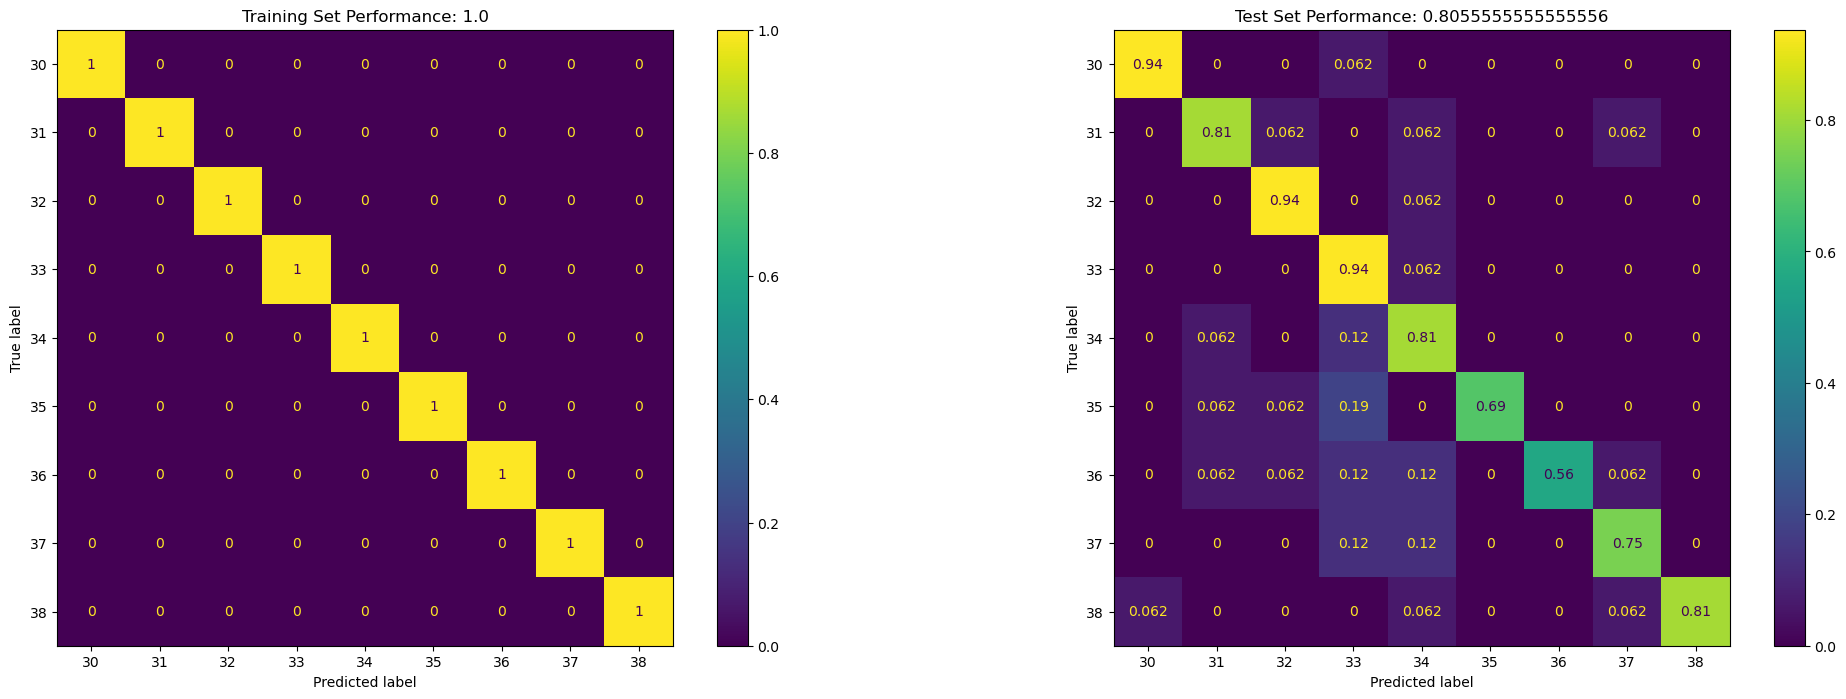

In [32]:
cknn_lda = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_lda.fit(transform_lda_gallery, gallery_gnd)
eval_model(cknn_lda, transform_lda_gallery, gallery_gnd, transform_lda_probe, probe_gnd)    

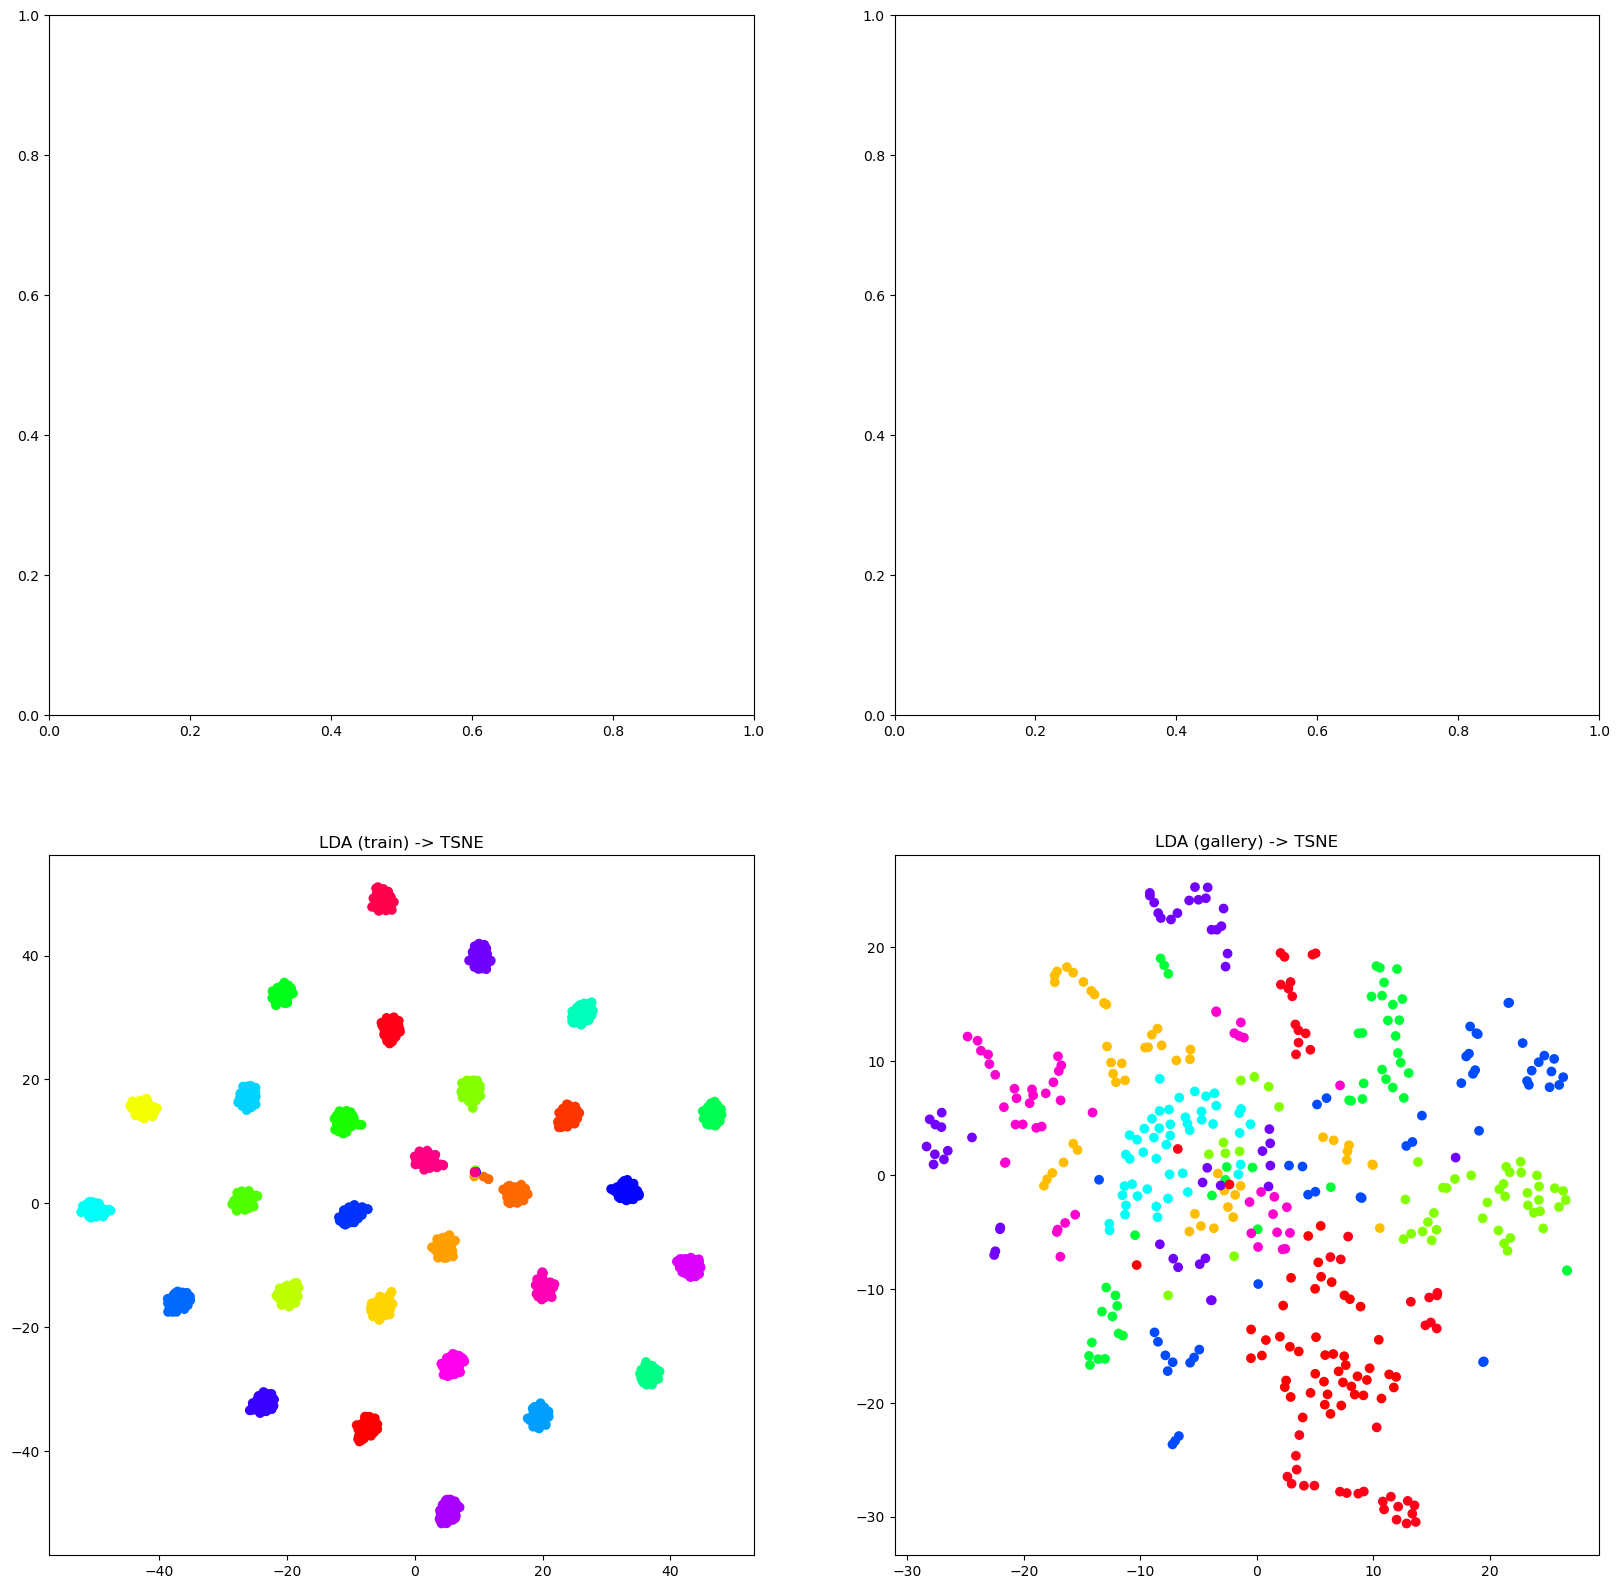

In [36]:
#embeddings_pca = TSNE(random_state=4).fit_transform(transformed_train_95)
embeddings_lda = TSNE(random_state=4).fit_transform(transform_lda_train)
embeddings_all = TSNE(random_state=4).fit_transform(transform_lda_gallery)

fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(2, 2, 1)
#ax.scatter(transformed_train_95[:,0], transformed_train_95[:,1], c=train_gnd, cmap='hsv')
#ax.set_title('Top 2 PCA')

ax = fig.add_subplot(2, 2, 2)
#ax.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=train_gnd, cmap='hsv')
#ax.set_title('PCA -> TSNE')

ax = fig.add_subplot(2, 2, 3)
ax.scatter(embeddings_lda[:,0], embeddings_lda[:,1], c=train_gnd, cmap='hsv')
ax.set_title('LDA (train) -> TSNE')

ax = fig.add_subplot(2, 2, 4)
ax.scatter(embeddings_all[:,0], embeddings_all[:,1], c=gallery_gnd, cmap='hsv')
ax.set_title('LDA (gallery) -> TSNE');

### Part 3 Other Databases
#### ORL

Follow data loading and splitting from Q1.

Once you have the data loaded and split, apply PCA then LDA, and evaluate face recognition performance.

In [44]:
orl = scipy.io.loadmat('ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

In [45]:
rng = numpy.random.default_rng(seed = 42)

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = rng.choice(indexes, 5, replace=False)
    test_frames = numpy.append(test_frames, f)

gallery_fea = fea
gallery_gnd = gnd
gallery_fea = numpy.delete(gallery_fea, test_frames, 0)
gallery_gnd = numpy.delete(gallery_gnd, test_frames, 0)
probe_fea = fea[test_frames, :]
probe_gnd = gnd[test_frames, :]
gallery_gnd = numpy.reshape(gallery_gnd, -1)
probe_gnd = numpy.reshape(probe_gnd, -1)

print(gallery_fea.shape)
print(gallery_gnd.shape)

(200, 1024)
(200,)


In [46]:
print(gallery_fea.shape)
transformed_gallery = pca.transform(gallery_fea)
transformed_probe = pca.transform(probe_fea)

print(transformed_gallery.shape)
transformed_gallery_for_lda = transformed_gallery[:, 0:dims_to_keep]
transformed_probe_for_lda = transformed_probe[:, 0:dims_to_keep]

print(transformed_gallery_for_lda.shape)

transform_lda_gallery = lda.transform(transformed_gallery_for_lda)
transform_lda_probe = lda.transform(transformed_probe_for_lda)

print(transform_lda_gallery.shape)

(200, 1024)
(200, 1024)
(200, 995)
(200, 28)


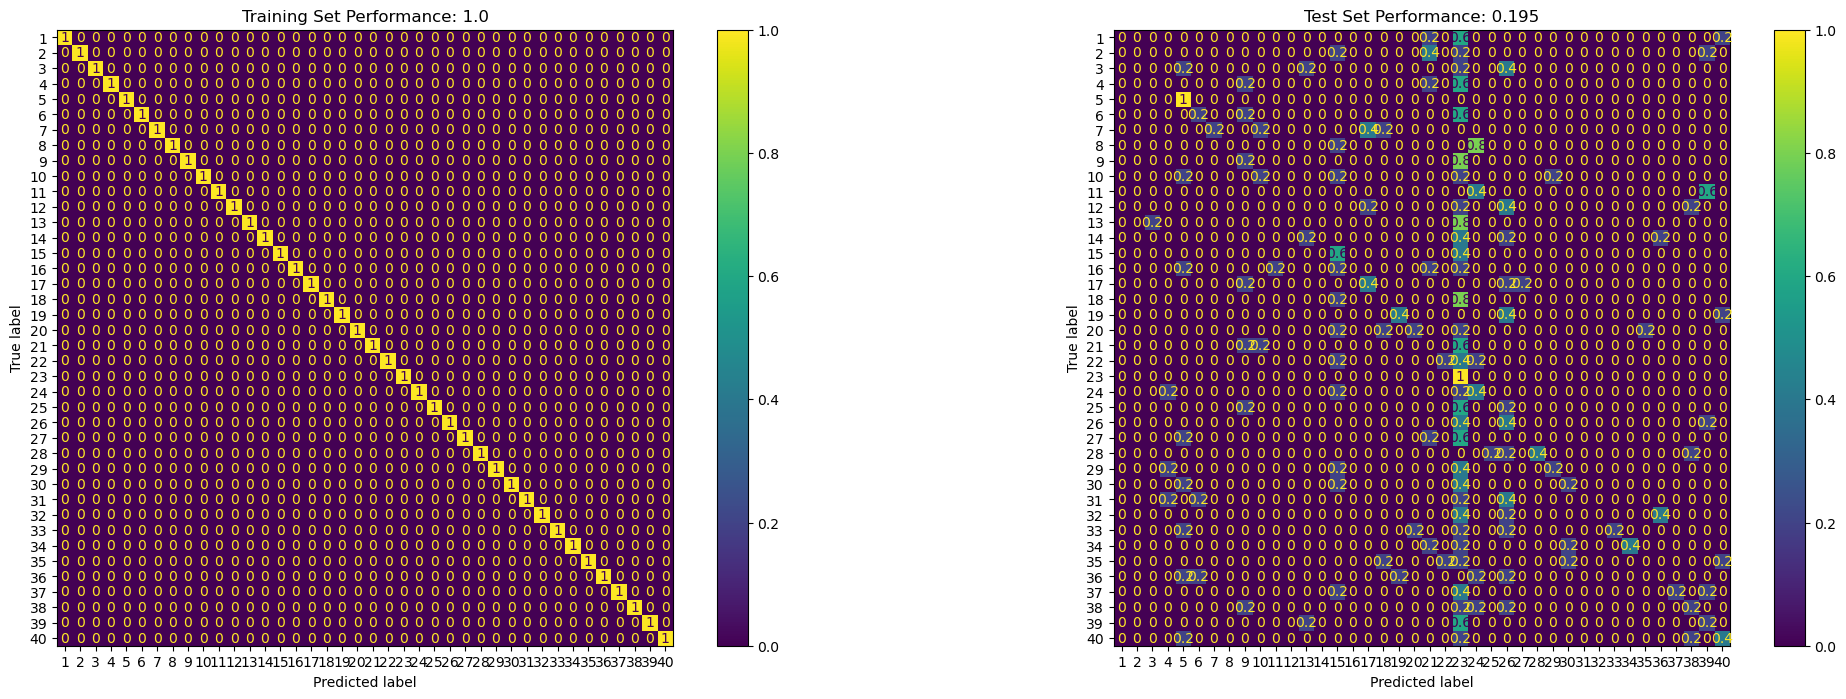

In [47]:
cknn_lda = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_lda.fit(transform_lda_gallery, gallery_gnd)
eval_model(cknn_lda, transform_lda_gallery, gallery_gnd, transform_lda_probe, probe_gnd)    

#### Yale

Follow data loading and splitting from Q1.

Once you have the data loaded and split, apply PCA then LDA, and evaluate face recognition performance.

In [48]:
yale = scipy.io.loadmat('Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

In [49]:
rng = numpy.random.default_rng(seed = 42)

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = rng.choice(indexes, 5, replace=False)
    test_frames = numpy.append(test_frames, f)

gallery_fea = fea
gallery_gnd = gnd
gallery_fea = numpy.delete(gallery_fea, test_frames, 0)
gallery_gnd = numpy.delete(gallery_gnd, test_frames, 0)
probe_fea = fea[test_frames, :]
probe_gnd = gnd[test_frames, :]
gallery_gnd = numpy.reshape(gallery_gnd, -1)
probe_gnd = numpy.reshape(probe_gnd, -1)

print(gallery_fea.shape)
print(gallery_gnd.shape)

(90, 1024)
(90,)


In [50]:
print(gallery_fea.shape)
transformed_gallery = pca.transform(gallery_fea)
transformed_probe = pca.transform(probe_fea)

print(transformed_gallery.shape)
transformed_gallery_for_lda = transformed_gallery[:, 0:dims_to_keep]
transformed_probe_for_lda = transformed_probe[:, 0:dims_to_keep]

print(transformed_gallery_for_lda.shape)

transform_lda_gallery = lda.transform(transformed_gallery_for_lda)
transform_lda_probe = lda.transform(transformed_probe_for_lda)

print(transform_lda_gallery.shape)

(90, 1024)
(90, 1024)
(90, 995)
(90, 28)


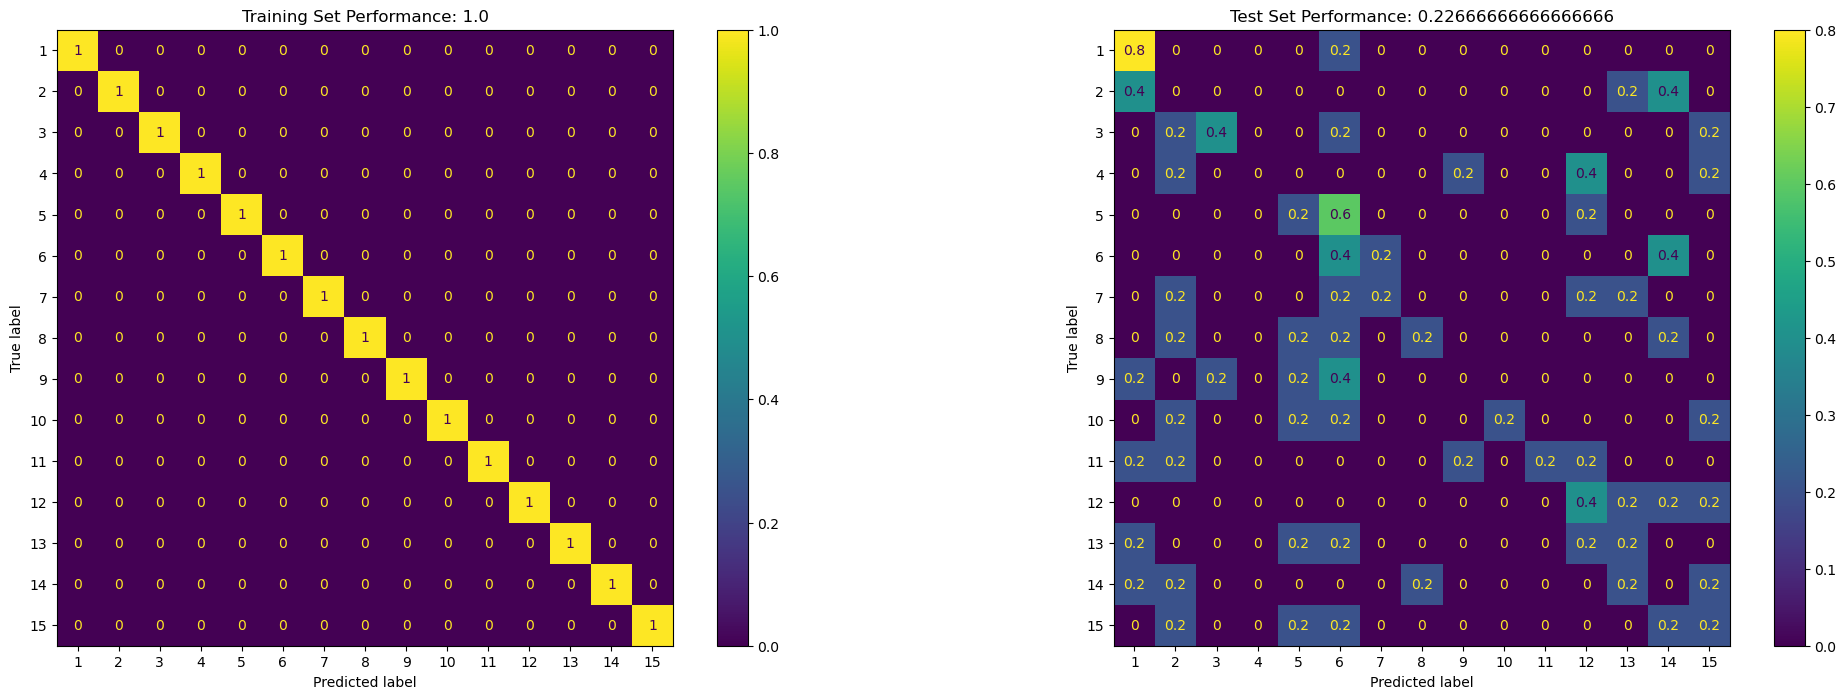

In [51]:
cknn_lda = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_lda.fit(transform_lda_gallery, gallery_gnd)
eval_model(cknn_lda, transform_lda_gallery, gallery_gnd, transform_lda_probe, probe_gnd)    